# esabin: a basic example
This example uses the current probability of seeing the aurora borealis (from the NOAA Space Weather Prediction Center).

This notebook compares the results of using equal-solid-angle bins and regular lat-lon bins

In [7]:
import requests, os

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

nowcastfn ='auroral_nowcast.json'

def download_auroral_nowcast():
    url = 'https://services.swpc.noaa.gov/json/ovation_aurora_latest.json'
    r = requests.get(url,allow_redirects=True)
    open(nowcastfn,'wb').write(r.content)
    return nowcastfn

if not os.path.exists(nowcastfn):
    download_auroral_nowcast()    
    
nowcast_dict = json.loads(open(nowcastfn,'r').read())
print('Using forcast from: {}'.format(nowcast_dict['Forecast Time']))
data = np.array(nowcast_dict['coordinates'],dtype=float)
lons,lats,prob_aurora = data[:,0],data[:,1],data[:,2]
northpole_mask = lats>50.
lons,lats,prob_aurora = lons[northpole_mask],lats[northpole_mask],prob_aurora[northpole_mask]

Using forcast from: 2022-01-12T18:49:00Z


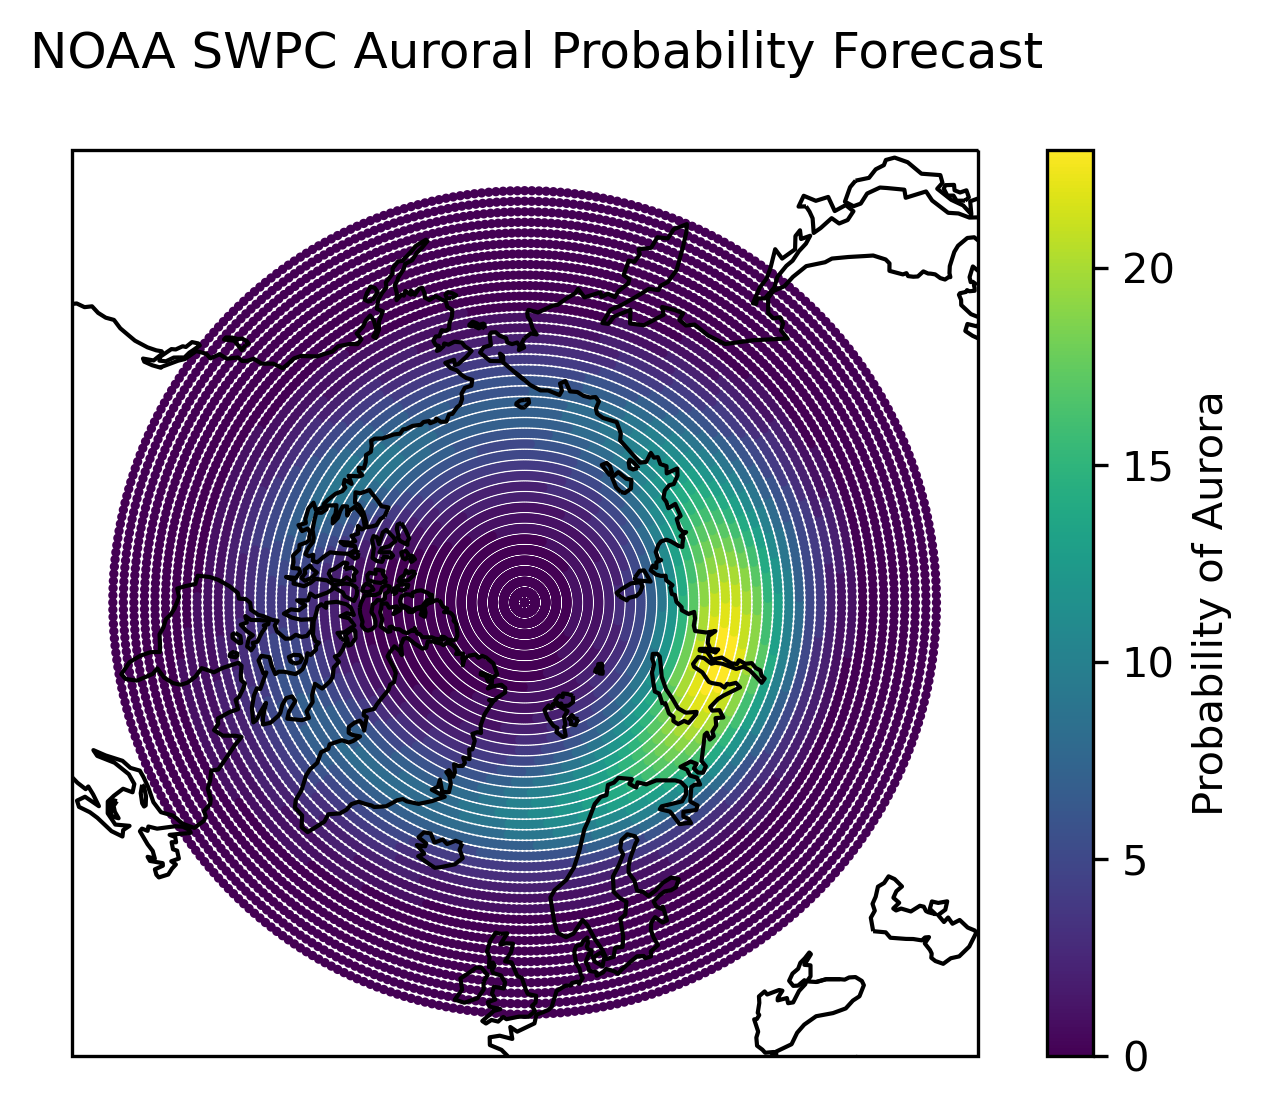

In [18]:
import cartopy.crs as ccrs

azeqkwargs = {'central_longitude':0.0,         
            'false_easting':0.0, 
            'false_northing':0.0,
            'globe':None}

projection_polar = ccrs.AzimuthalEquidistant(central_latitude=90.0,**azeqkwargs)
transform = ccrs.PlateCarree()

fmap = plt.figure(figsize=(6,4),dpi=300)
axmap = fmap.add_subplot(111,projection=projection_polar)
axmap.coastlines()
#axmap.gridlines(draw_labels=True)
mappable = axmap.scatter(lons,lats,1.5,prob_aurora,transform=transform)
fmap.colorbar(mappable,label='Probability of Aurora')
fmap.suptitle('NOAA SWPC Auroral Probability Forecast')
fmap.savefig('swpc_aurora_unbinned.png')
plt.show()

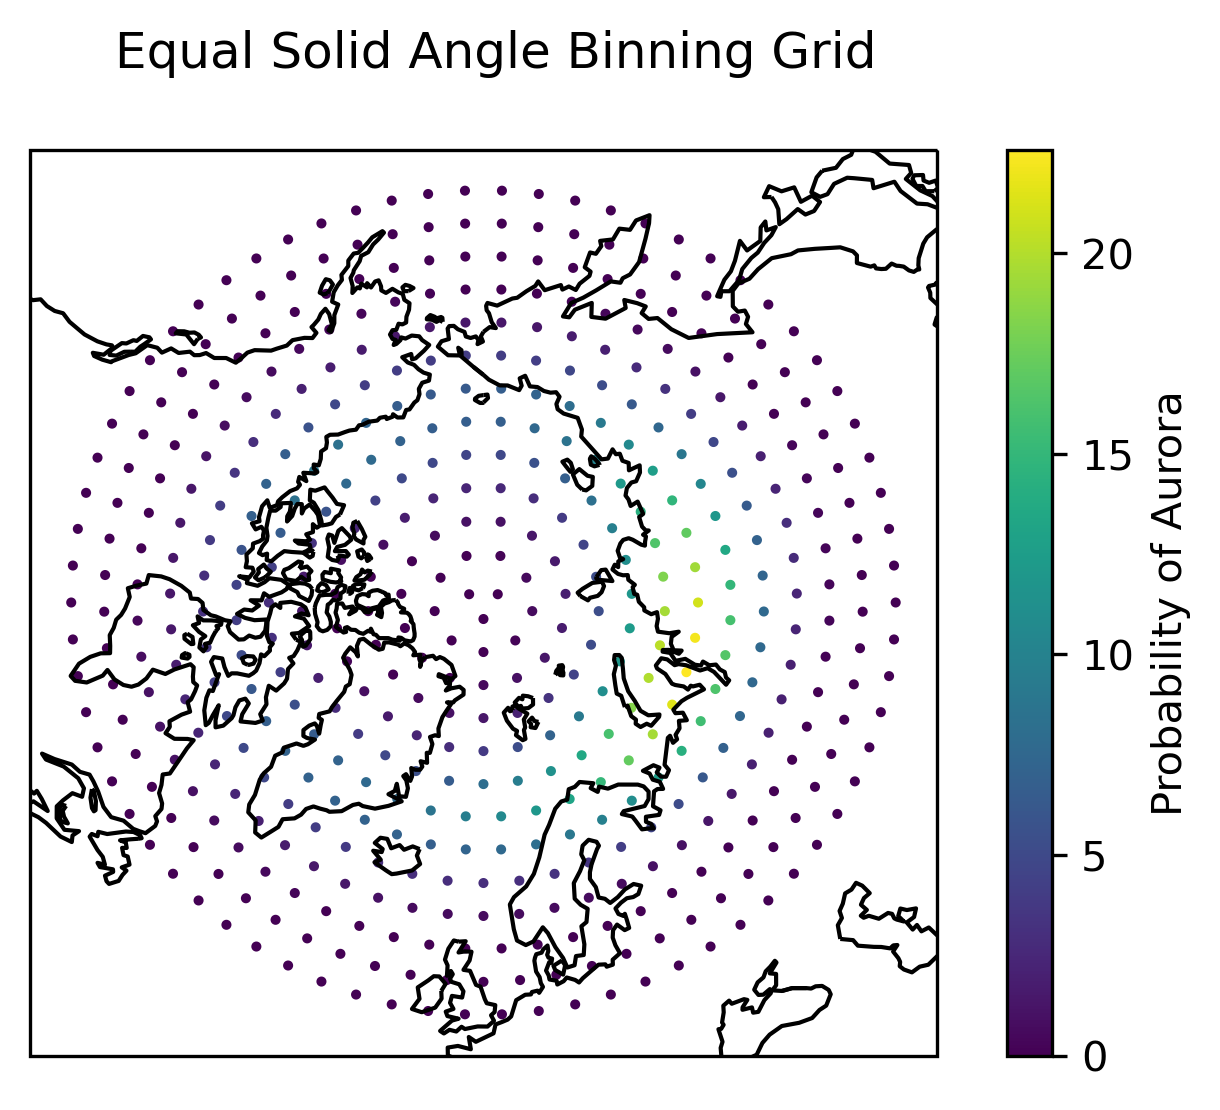

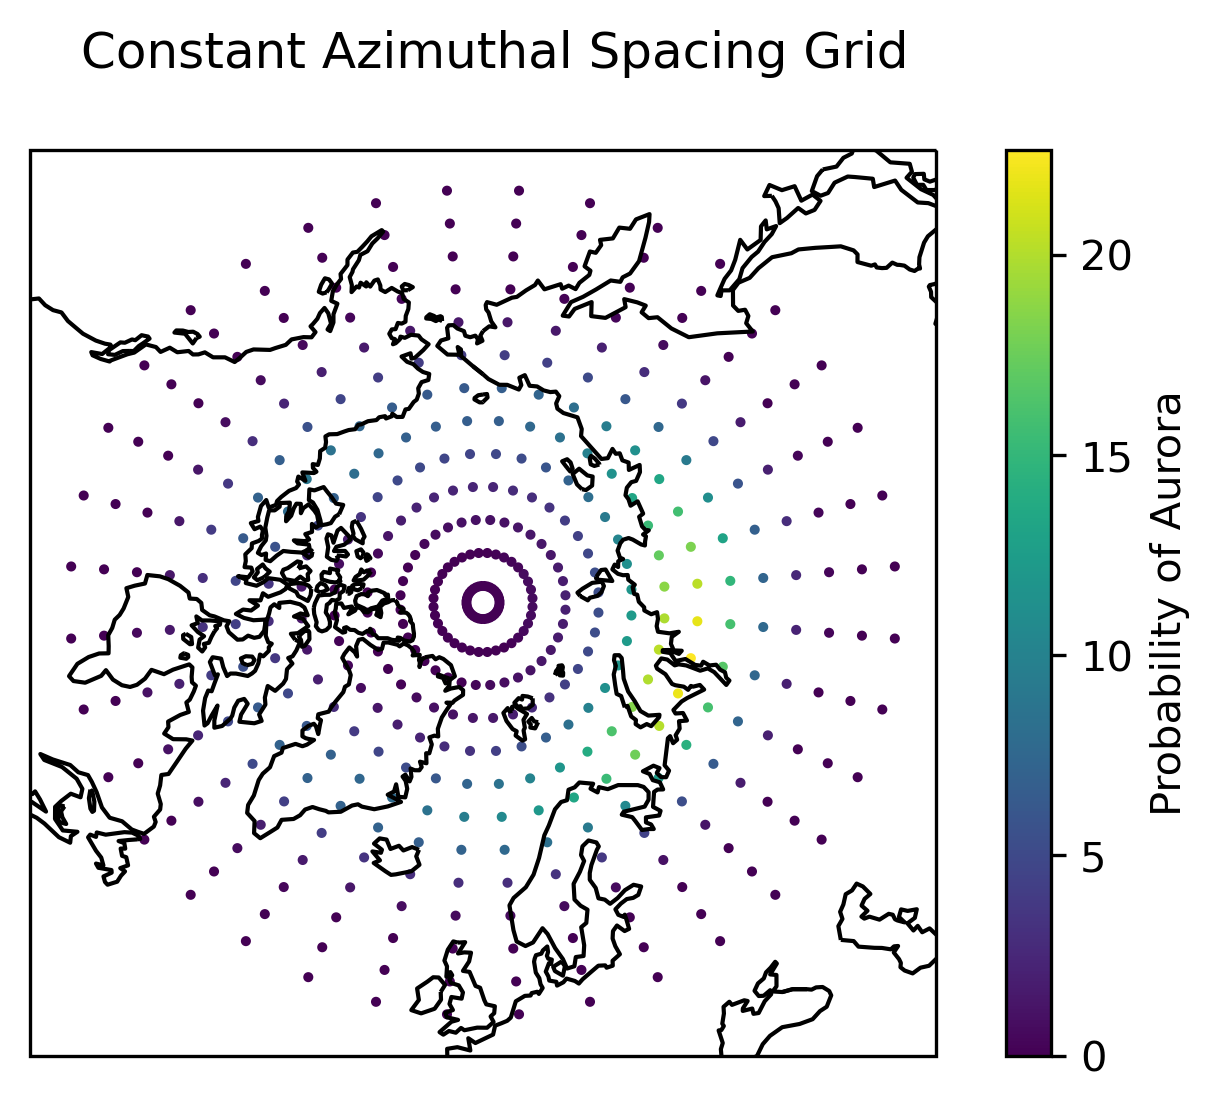

In [20]:
from esabin.esagrid import Esagrid
from esabin.esagrid import ConstantAzimuthalSpacingGrid
egrid = Esagrid(delta_lat=3,n_cap_bins=3,azi_coord='lon')
rgrid = ConstantAzimuthalSpacingGrid(delta_lat=3,delta_azi=10,azi_coord='lon')

for grid,kind in [(egrid,'equalsolidangle'),(rgrid,'constantazi')]:
    bin_lat,bin_lon,bin_mean = grid.bin_stats(lats,lons,prob_aurora,center_or_edges='center')
    
    fmap = plt.figure(figsize=(6,4),dpi=300)
    axmap = fmap.add_subplot(111,projection=projection_polar)
    axmap.coastlines()
    mappable = axmap.scatter(bin_lon,bin_lat,2,bin_mean,transform=transform)
    fmap.colorbar(mappable,label='Probability of Aurora')
    fmap.suptitle('{}\n'.format(str(grid).split('\n')[0]))
    fmap.savefig('swpc_aurora_{}.png'.format(kind))
    plt.show()
    